Bilayer unit domain. Sigma optimisation

In [1]:
# Importing libraries
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
from mpi4py import MPI
from ufl import (
    inner,
    grad,
    conj,
    TrialFunction,
    TestFunction,
    as_matrix,
    as_vector,
    dot,
    Or,
    Measure,
    conditional,
    SpatialCoordinate,
)
from dolfinx.mesh import locate_entities_boundary, create_interval, locate_entities, create_submesh
from dolfinx.fem import FunctionSpace, Function, functionspace, Function, dirichletbc, locate_dofs_topological, petsc, form, assemble_matrix
import basix
from petsc4py.PETSc import ScalarType
from slepc4py.SLEPc import EPS  
colors_list = ["blue", "green", "red", "magenta", "black", "purple", "orange", "brown", "pink"]


/home/srecondo/miniconda3/envs/cleaned-fenicsx/lib/python3.10/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


Domain, PML, refinement and physical configurations

In [2]:
# Define element size for the mesh refinement
h_i = [0.125/4,]
    # 0.0625,
    # 0.0625 / 2,
    # 0.0625 / 4,
    # 0.0625 / 8]

# Domain configuration
Lx = 1. # fluid domain length (without PML)
l_inner=Lx/2

# Physical configuration
rho_media_1 = 1. # kg/m^3 
vel_media_1 = 2.   # m/s
rho_media_2 = 1. # kg/m^3 
vel_media_2 = 1.   # m/s


# Define the density and velocity functions  
def rho_function(x):    
    return np.where(x[0] > l_inner, rho_media_2,rho_media_1)

def vel_function(x):    
    return np.where(x[0] > l_inner, vel_media_2,vel_media_1)

# PML configuration
pml_thickness = Lx/4
# sigma_0 = 1 #0.484375

# Solver configuration

requested_eigenvalues_number = 50 # Number of eigenvalues to compute

Solver configuration and computing

In [3]:
def get_configured_problem(mesh, degrees, sigma_x):
    # Initialize dictionaries
    dof = {}
    solver_dict={}
    V_dict={}
    Q_dict={}

    # Define finite element spaces
    p_fe_type = basix.ufl.element(family="Lagrange", cell=mesh.basix_cell(), degree=degrees[0])
    v_fe_type = basix.ufl.element(family="DG", cell=mesh.basix_cell(), degree=degrees[1], shape=(mesh.geometry.dim,))
    FE = {"p": p_fe_type, "v": v_fe_type}

    # Create a submesh of PML associated cells
    tdim = mesh.topology.dim

    # Identify the fluid cells
    # fluid_cells = locate_entities(mesh, tdim, lambda x: x[0] <= Lx)

    # Create function spaces for mesh and submesh
    Q = functionspace(mesh,FE["p"])
    V = functionspace(mesh, FE["v"])

    # Dictionaries to store the number of dofs
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global

    # Boundary conditions application (for pressure)
    bc = []
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], 0.0))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 
    
    facets = locate_entities_boundary(mesh, 0, lambda x: np.isclose(x[0], Lx+pml_thickness))
    o_boundary_dofs = locate_dofs_topological(Q, 0, facets)  # the dimension is related to mesh entity where dofs are located

    # Setting to zero located dofs related to boundaries
    u_d = Function(Q)
    u_d.x.array[:] = 0.0  # Asign Dirichlet condition value
    bc.append(dirichletbc(u_d, o_boundary_dofs)) 

    # Define differential operators
    dx = Measure("dx", domain=mesh)

    # Interpolates the density and velocity functions
    W = functionspace(mesh, ("DG", 2))
    rho = Function(W)
    rho.interpolate(rho_function)
    c = Function(W)
    c.interpolate(vel_function)

    # Spatial Coordinate is updated for the actual mesh
    x = SpatialCoordinate(mesh)

    # Variation formulation definition
    p = TrialFunction(Q) 
    v = TrialFunction(V)
    q = TestFunction(Q)
    w = TestFunction(V)

    # Define the variational forms
    a = form(
        [
            [sigma_x(x) / (rho * c**2) * p * conj(q) * dx, -1 * inner(v, grad(q)) * dx],
            [inner(grad(p), w) * dx, sigma_x(x) * rho * inner(v, w) * dx],
        ]
    )
    b = form(
        [
            [1.0 / (rho * c**2) * p * conj(q) * dx, None],
            [None, rho * inner(v, w) * dx],
        ]  
    )
    # Assemble matrices
    A = petsc.assemble_matrix_block(a, bcs=bc)
    A.assemble()
    B = petsc.assemble_matrix_block(b, bcs=bc)
    B.assemble()

    # SLEPc solver configuration for linear eigenvalue problem (A x =\lambda x B)
    solver = EPS().create()
    solver.setOperators(-A, B)
    solver.setType("arnoldi")
    solver.setWhichEigenpairs(9)  # TARGET_IMAGINARY = 9, TARGET_MAGNITUDE = 7, TARGET_REAL = 8
    solver.setDimensions(
        requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
        4 * requested_eigenvalues_number,
    )
    solver.setTolerances(1e-7, 100)
    st = solver.getST()
    st.setType("sinvert")  # Applying spectral transformation "shift and invert" 
    solver.setTarget(-2.5j)  
    solver.solve()
    n_eigs_converged_quadratic = solver.getConverged()

    return solver, mesh, Q, V, dof

Approx eigenvalues calculation

In [4]:
def get_approx_eigenpair(solver, selected_index, Q, V, dof):
    # Gets p, v eigenvectors
    p_h = Function(Q, name="p")
    v_h = Function(V, name="v")
    dof["p"] = Q.dofmap.index_map.size_global
    dof["v"] = V.dofmap.index_map.size_global
    [vrA, viA] = solver.getOperators()[0].getVecs()  # type: ignore

    # Filtrar eigenvalores con parte real mayor que 1e-12
    eigenvalues = []
    for i in range(solver.getConverged()):
        omega_value = solver.getEigenpair(i, vrA) * (1j)  # type: ignore
        if omega_value.real > 1e-12:
            eigenvalues.append((omega_value, vrA.copy()))

    # Seleccionar el n-ésimo eigenvalor filtrado
    omega_value, vrA = eigenvalues[selected_index]

    # FEM approximation for the eigenfunction
    p_h.x.petsc_vec.array[:] = vrA[0 : dof["p"]]
    p_h.x.petsc_vec.array[:] = p_h.x.petsc_vec.array[:] / p_h.eval([Lx, 0.0, 0.0], 1)  # normalise
    v_h.x.petsc_vec.array[:] = vrA[dof["p"] :]  
    v_h.x.petsc_vec.array[:] = v_h.x.petsc_vec.array[:] / v_h.eval([Lx, 0.0, 0.0], 1)  # normalise

    return [omega_value, p_h, v_h]  # Return eigenfunction and eigenvalue

In [5]:
def get_exact_eigenvalue(n):
    # Exact eigenvalues for the problem
    exact_physical_eigs_function= lambda n: vel_media_1 / l_inner * np.arctan(-1j * (vel_media_2 * rho_media_2) / (vel_media_1 * rho_media_1))+ n * np.pi * vel_media_1 / l_inner
    return exact_physical_eigs_function(n)

In [6]:
def get_exact_eigenpair(solver, selected_index, Q, V, x_hat, sigma_x, gamma_x):
    exact_physical_eigs_function= lambda n: vel_media_1 / l_inner * np.arctan(-1j * (vel_media_2 * rho_media_2) / (vel_media_1 * rho_media_1))+ n * np.pi * vel_media_1 / l_inner
    w=exact_physical_eigs_function(selected_index)

    p_1 = lambda x: np.sin(w * x[0] / vel_media_1)
    p_2 = lambda x: -np.sin(-w * l_inner / vel_media_1) * np.exp(1j * w / vel_media_2 * (x_hat(x,w) - l_inner))
    p = lambda x: np.where(x[0] == Lx + pml_thickness, 0, np.where(x[0] >= l_inner, p_2(x), p_1(x)))

    # sigma_x = lambda x: np.where(x[0] >= l_inner, sigma_0, 0)
    sigma_x_function_cond= lambda x: np.where(x[0]<=Lx, x[0]*0., np.where(x[0] == Lx + pml_thickness, x[0]*0.0+1e10, sigma_x(x)))
    v_1=lambda x: 1/(-1j*w)*(w / vel_media_1) * np.cos(w * x[0] / vel_media_1)
    v_2 = (lambda x: 1/(-1j*w+sigma_x_function_cond(x)*rho_media_1)* -np.sin(-w * l_inner / vel_media_1) *(1j * w / vel_media_2)
        * np.exp(1j * w / vel_media_2 * (x_hat(x,w) - l_inner))* gamma_x(x, w)[0])
    v = lambda x: np.where(x[0] >= l_inner, v_2(x), v_1(x))

    p_ex = Function(Q, name="p_ex")
    p_ex.interpolate(p)
    p_ex.x.petsc_vec.array[:] = p_ex.x.petsc_vec.array[:] / p_ex.eval(np.array([Lx, 0.0, 0.0]), 1)

    v_ex = Function(V, name="v_ex")
    v_ex.interpolate(v)
    v_ex.x.petsc_vec.array[:] = v_ex.x.petsc_vec.array[:] / v_ex.eval(np.array([Lx, 0.0, 0.0]), 1)

    return [w, p_ex, v_ex]

quadratic

In [7]:
degree=[2,1]

In [8]:
sigma_sweep_piecewise=np.linspace(12.5, 30, 11)
sigma_sweep_quadratic=np.linspace(40, 100, 11)
sigma_sweep_singular=np.linspace(0.5, 4., 11)

In [9]:
def get_closer_approx_eig(exact, solver, Q, V, dof, number_of_values=0):
    error = []
    for j in np.arange(number_of_values):
        error.append(np.abs(exact - get_approx_eigenpair(solver, j, Q, V, dof)[0]) / np.abs(exact))

    index_closest_eig = np.argmin(error)
    return get_approx_eigenpair(solver, index_closest_eig, Q, V, dof)[0], index_closest_eig

In [10]:
exact_omega = [None] * 5 
for j in np.arange(0, 5,1):
    exact_omega[j] = get_exact_eigenvalue(j)

In [11]:
# Initialize lists to store the approximated eigenpairs
approx_piecewise = [[0 for _ in range(5)] for _ in range(len(sigma_sweep_piecewise))]
approx_quadratic = [[0 for _ in range(5)] for _ in range(len(sigma_sweep_quadratic))]
approx_singular = [[0 for _ in range(5)] for _ in range(len(sigma_sweep_singular))]

for i,sigma_0_piecewise, sigma_0_quadratic, sigma_0_singular in zip(range(len(sigma_sweep_piecewise)),sigma_sweep_piecewise, sigma_sweep_quadratic, sigma_sweep_singular):
    # Create mesh depending on h
    mesh = create_interval(MPI.COMM_WORLD, int((Lx + pml_thickness )/ h_i[0]), [0, Lx + pml_thickness])

    # Define quadratic sigma function
    sigma_x_piecewise=lambda x: conditional(x[0] > l_inner, sigma_0_piecewise, 0.0)
    sigma_x_quadratic=lambda x: conditional(x[0] > Lx, sigma_0_quadratic*(x[0]-Lx)**2, 0.0)
    sigma_x_singular=lambda x: conditional(x[0] > Lx, sigma_0_singular/(Lx+pml_thickness-x[0]), 0.0)

    # Define solver for quadratic PML
    [solver_piecewise, mesh, Q_, V_, dof_]=get_configured_problem(mesh, degree, sigma_x_piecewise)
    [solver_quadratic, mesh, Q_, V_, dof_]=get_configured_problem(mesh, degree, sigma_x_quadratic)
    [solver_singular, mesh, Q_, V_, dof_]=get_configured_problem(mesh, degree, sigma_x_singular)

    for j in np.arange(0, 5,1):
        # Get the approximated eigenpair
        approx_piecewise[i][j] = get_closer_approx_eig(exact_omega[j], solver_piecewise, Q_, V_, dof_, 15)[0]
        approx_quadratic[i][j] = get_closer_approx_eig(exact_omega[j], solver_quadratic, Q_, V_, dof_, 15)[0]
        approx_singular[i][j] = get_closer_approx_eig(exact_omega[j], solver_singular, Q_, V_, dof_, 15)[0]

# Ordenar cada fila de la lista
for i in range(len(approx_piecewise)):
    approx_piecewise[i] = sorted(approx_piecewise[i], key=lambda x: x.real)
    approx_quadratic[i] = sorted(approx_quadratic[i], key=lambda x: x.real)
    approx_singular[i] = sorted(approx_singular[i], key=lambda x: x.real)


In [12]:
exact_omega

[np.complex128(-2.197224577336219j),
 np.complex128(12.566370614359172-2.197224577336219j),
 np.complex128(25.132741228718345-2.197224577336219j),
 np.complex128(37.69911184307752-2.197224577336219j),
 np.complex128(50.26548245743669-2.197224577336219j)]

In [13]:
approx_piecewise

[[(2.1131703961751445-11.760534497630212j),
  (12.395094950117057-2.302297199460229j),
  (24.764768827951887-2.263768191835992j),
  (37.100114368604174-2.225940672623047j),
  (48.80817748289432-11.821088676087365j)],
 [(2.1105876054282775-13.511931783935387j),
  (12.391066862263363-2.327697630151785j),
  (24.759179220683794-2.29370553671529j),
  (37.09607323696887-2.2606153288627717j),
  (48.80896958143407-13.573541567840218j)],
 [(12.38751565340739-2.3535001128079007j),
  (12.38751565340739-2.3535001128079007j),
  (24.75426100908435-2.3236327384563236j),
  (37.09257953686493-2.2949070309781527j),
  (37.09257953686493-2.2949070309781527j)],
 [(12.384395382170046-2.3796572051272715j),
  (12.384395382170046-2.3796572051272715j),
  (24.749956736600264-2.3535468007559928j),
  (37.08959360092304-2.3288493894432527j),
  (37.08959360092304-2.3288493894432527j)],
 [(12.381665736563615-2.4061246375066485j),
  (12.381665736563615-2.4061246375066485j),
  (24.74621542202679-2.383443325937419j),
  

In [14]:
# sigma_quadratic_absorption=(Lx+pml_thickness)**3/3-Lx*(Lx+pml_thickness)**2+Lx**2*(Lx+pml_thickness)-sigma_0*Lx**3/3
# sigma_piecewise_absorption=sigma_0*pml_thickness
# sigma_singular_absorption=1e40

In [15]:
def group_by_real_part(eigenvalues, tolerance=1):
    groups = []
    for row in eigenvalues:
        for eig in row:
            added = False
            for group in groups:
                if abs(group[0].real - eig.real) < tolerance:
                    group.append(eig)
                    added = True
                    break
            if not added:
                groups.append([eig])
    return groups

groups_piecewise = group_by_real_part(approx_piecewise)
groups_quadratic = group_by_real_part(approx_quadratic)
groups_singular = group_by_real_part(approx_singular)

In [16]:
rel_error_eig_0_piecewise=abs((groups_piecewise[0] - exact_omega[1])) / np.abs(exact_omega[1]) 
rel_error_eig_1_piecewise=abs((groups_piecewise[1] - exact_omega[2])) / np.abs(exact_omega[2]) 

rel_error_eig_0_quadratic=abs((groups_quadratic[0] - exact_omega[1])) / np.abs(exact_omega[1]) 
rel_error_eig_1_quadratic=abs((groups_quadratic[1] - exact_omega[2])) / np.abs(exact_omega[2]) 

rel_error_eig_0_singular=abs((groups_singular[0] - exact_omega[1])) / np.abs(exact_omega[1]) 
rel_error_eig_1_singular=abs((groups_singular[1] - exact_omega[2])) / np.abs(exact_omega[2]) 

In [18]:
# plt.plot(sigma_sweep_piecewise,rel_error_eig_0_piecewise)
# plt.plot(sigma_sweep_piecewise[np.argmin(rel_error_eig_0_piecewise)], rel_error_eig_0_piecewise[np.argmin(rel_error_eig_0_piecewise)], '*', label='$\sigma_0='+str(sigma_sweep_piecewise[np.argmin(rel_error_eig_0_piecewise)])+'$')
# plt.xlabel('$\sigma_0$')
# plt.ylabel('$\epsilon_r$')
# plt.grid(True)
# _=plt.legend()

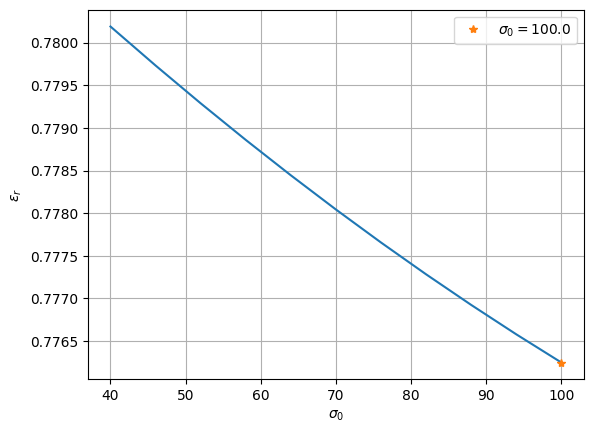

In [19]:
plt.plot(sigma_sweep_quadratic,rel_error_eig_0_quadratic)
plt.plot(sigma_sweep_quadratic[np.argmin(rel_error_eig_0_quadratic)], rel_error_eig_0_quadratic[np.argmin(rel_error_eig_0_quadratic)], '*', label='$\sigma_0='+str(sigma_sweep_quadratic[np.argmin(rel_error_eig_0_quadratic)])+'$')
plt.xlabel('$\sigma_0$')
plt.ylabel('$\epsilon_r$')
plt.grid(True)
_=plt.legend()

ValueError: x and y must have same first dimension, but have shapes (11,) and (2,)

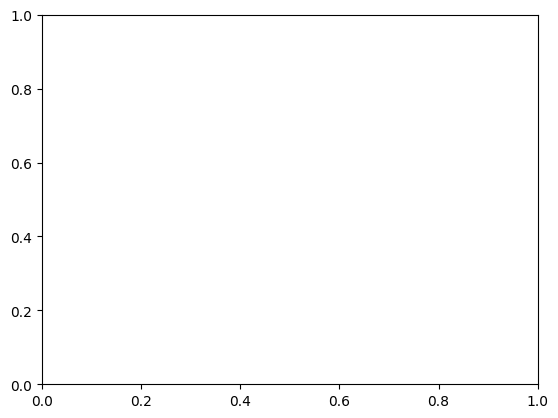

In [ ]:
plt.plot(sigma_sweep_singular,rel_error_eig_0_singular)
plt.plot(sigma_sweep_singular[np.argmin(rel_error_eig_0_singular)], rel_error_eig_0_singular[np.argmin(rel_error_eig_0_singular)], '*', label='$\sigma_0='+str(sigma_sweep_singular[np.argmin(rel_error_eig_0_singular)])+'$')
plt.xlabel('$\sigma_0$')
plt.ylabel('$\epsilon_r$')
plt.grid(True)
_=plt.legend()